# Importing Libraries
*     Using VaderSentiment instead of Text Blob to give label to texual data

In [ ]:
!pip install vaderSentiment 

In [1]:
import requests
import time
import pandas as pd
import yfinance as yf
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import re
from tabulate import tabulate
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amarc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
api_key = 'l8PWoA5GCTKqnVrGtxZSACvbnmDPhlRg'

# *Extracting data from New York Times  API*
*      *Currently for TSLA and AAPL Stock*

In [3]:
# stocks_list=['AAPL','GSPC','S&P500','MSFT','NVDA','GOOG','META','TSLA','JPM','WMT'
#              'UltraTechCement','Shree Cements','Ambuja Cements']

In [ ]:

def fetch_data(year, month, api_key):
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        articles = data['response']['docs']
        return articles
    else:
        print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
        return []

# Initialize lists for headlines and dates
all_headlines = []
all_dates = []

# API key
api_key = 'Z7LiuLGnozS868StkM3QcbQhsJA8acDt'

# Fetch data for each year from 2010 to 2024
for year in range(2010, 2015):
    for month in range(1, 13):
        print(f"Fetching data for {year}-{month}")
        try:
            articles = fetch_data(year, month, api_key)
            if articles:
                all_headlines.extend([article['headline']['main'] for article in articles])
                all_dates.extend([article['pub_date'] for article in articles])
            # Sleep to respect API rate limits
            time.sleep(6)  # Adjust sleep time as needed based on API rate limits
        except Exception as e:
            print(f"Error fetching data for {year}-{month}: {e}")

# Create a DataFrame
df = pd.DataFrame({'datetime': all_dates, 'news': all_headlines})

# Convert datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract date
df['date'] = df['datetime'].dt.date

# Filter articles containing information about Apple company stock
keywords = ['Tesla', 'TSLA', 'Elon Musk Tesla', 'Tesla stock', 'Tesla shares']
df['contains_tsla_stock_info'] = df['news'].apply(lambda x: any(keyword in x for keyword in keywords))

# Create a filtered DataFrame
tesla_stock_df = df[df['contains_tsla_stock_info']]

# Group by date and concatenate news articles
grouped_tesla_df = tesla_stock_df.groupby('date')['news'].agg(' '.join).reset_index()

# Rename columns and convert Date to datetime format
grouped_tesla_df.columns = ['Date', 'news_articles']
grouped_tesla_df['Date'] = pd.to_datetime(grouped_tesla_df['Date'])

# Print the resulting DataFrame
print(grouped_tesla_df)

In [5]:
# grouped_tesla_df.to_csv('final_data.csv')

In [6]:
# data=pd.read_csv('data/tesla.csv')
data=pd.read_csv('data/apple.csv')

In [7]:
data.shape

(985, 3)

# *For Data Cleaning And Pre-Processing*

In [8]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower()) # removing unwanted symbols
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')] # removing stop words
    return ' '.join(tokens)

# *Using VaderSentiment Analysis*

In [9]:
# Intializing VaderSentiment Analysis class
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


In [10]:
data['processed_news_articles'] = data['news_articles'].apply(preprocess_text)
data

,Unnamed: 0,Date,news_articles,processed_news_articles
0,0,2010-01-04,"Is It Live, or Is It iTunes? Apple Store as Re...",live itunes apple store recital space
1,1,2010-01-05,"Apple Buys Quattro, a Mobile Ad Company Apple ...",apple buys quattro mobile ad company apple buy...
2,2,2010-01-06,Microsoft and H.P. to Reveal Slate PC Ahead of...,microsoft hp reveal slate pc ahead apple micro...
3,3,2010-01-07,Apple Patent Application Could Presage Thinner...,apple patent application could presage thinner...
4,4,2010-01-13,Elevation’s Latest Hire Is Another Apple Alum,elevations latest hire another apple alum
...,...,...,...,...
980,980,2023-11-12,"You Paid $1,000 for an iPhone, but Apple Still...",paid 1000 iphone apple still controls
981,981,2023-11-17,Big Apple Circus Review: A Show That Bends Ove...,big apple circus review show bends backward
982,982,2023-11-18,Apple Says It Will Improve the Green vs. Blue ...,apple says improve green vs blue texting exper...
983,983,2023-11-20,This Is Why Google Paid Billions for Apple to ...,google paid billions apple change single setting


In [11]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

# *Generating labels aka Signals*
*         * 1 indicates buy signal *
*        * -1 indicates sell signal*
*         * 0 indicates no signal  *

In [12]:
data['sentiment'] = data['processed_news_articles'].apply(get_sentiment)

In [13]:
data['sentiment'].value_counts()

sentiment
Neutral     457
Positive    291
Negative    237
Name: count, dtype: int64

In [14]:
l={'Neutral':0,'Positive':1,'Negative':-1}
data['numerical_sentiment']=data['sentiment'].map(l)

In [15]:
data.set_index('Date',inplace=True)

In [16]:
data.index=pd.to_datetime(data.index)

In [17]:
data.head()

,news_articles,processed_news_articles,sentiment,numerical_sentiment
Date,,,,
2010-01-04,"Is It Live, or Is It iTunes? Apple Store as Re...",live itunes apple store recital space,Neutral,0
2010-01-05,"Apple Buys Quattro, a Mobile Ad Company Apple ...",apple buys quattro mobile ad company apple buy...,Positive,1
2010-01-06,Microsoft and H.P. to Reveal Slate PC Ahead of...,microsoft hp reveal slate pc ahead apple micro...,Neutral,0
2010-01-07,Apple Patent Application Could Presage Thinner...,apple patent application could presage thinner...,Neutral,0
2010-01-13,Elevation’s Latest Hire Is Another Apple Alum,elevations latest hire another apple alum,Neutral,0


# *Importing Financial Data from YFinance*

In [18]:
# ticker = 'TSLA'
ticker='AAPL'
start_date = '2010-01-01'
end_date = '2024-01-01'
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [19]:
df['Signals'] = 0
for i in range(df.shape[0]):
    date = pd.Timestamp(df.index[i])  # Convert index to Timestamp
    if date in data.index:
        df.loc[date, 'Signals'] = data.loc[date, 'numerical_sentiment']
    else:
        df.loc[date, 'Signals'] = 0

In [20]:
df['Signals'].value_counts()

Signals
 0    3055
 1     262
-1     205
Name: count, dtype: int64

In [21]:
df

,Open,High,Low,Close,Adj Close,Volume,Signals
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600,0
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481927,601904800,1
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378826,552160000,0
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,0
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,0
...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,0
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,0


In [22]:
buy=[]
sell=[]
for i in range(df.shape[0]):
    if df.Signals[i]==1:
        buy.append(df.Close[i])
        sell.append(np.nan)
    elif df.Signals[i]==-1:
        buy.append(np.nan)
        sell.append(df.Close[i])
    else:
        buy.append(np.nan)
        sell.append(np.nan)

dff=df.copy()
dff['Buy']=buy
dff['Sell']=sell

# *Plotting Buy and Sell Signals in Graph*

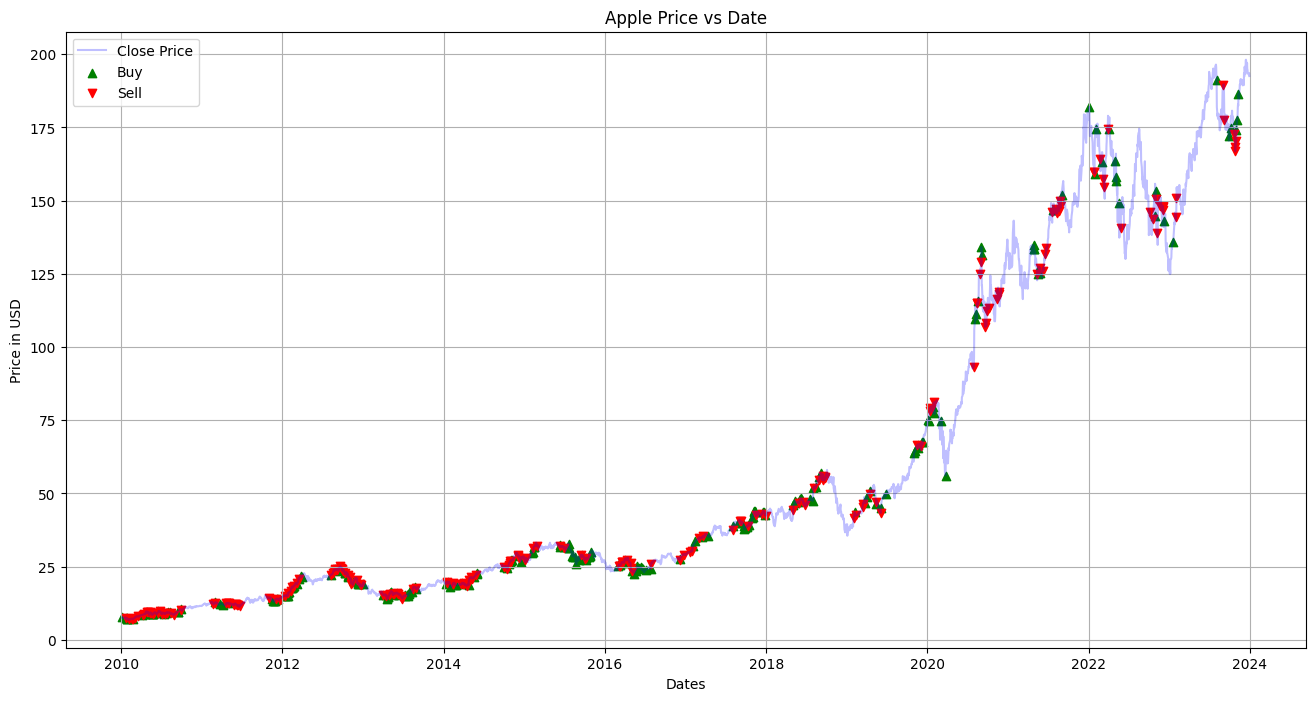

In [23]:
# Plot the close price , bollinger bands and trading signals(buy & sell signals)
fig,ax=plt.subplots(figsize=(16,8))
plt.title('Apple Price vs Date')
plt.grid(True)
plt.ylabel('Price in USD')
plt.xlabel('Dates')
ax.plot(df['Close'],label='Close Price',alpha=0.25,color='blue')
ax.scatter(dff.index,dff['Buy'],label='Buy',alpha=1,marker='^',color='green')
ax.scatter(dff.index,dff['Sell'],label='Sell',alpha=1,marker='v',color='red')
plt.legend()
plt.show()

In [24]:
# We used average true range for finding the range of take profit and stop loss
def average_true_range(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = (data['High'] - data['Close']).abs()
    low_close = (data['Low'] - data['Close']).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=window).mean()
    return data

In [25]:
# This is take profit and stop loss function
def tpsl(data):
    # Initialize columns with NaN
    data['Take Profit'] = np.nan
    data['Stop Loss'] = np.nan
    for i in range(len(data)):
        if data.iloc[i]['Signals'] == 1:  # Check for Buy signal
            data.at[data.index[i], 'Take Profit'] = 15.0 * data.iloc[i]['ATR']
            data.at[data.index[i], 'Stop Loss'] = 12.0 * data.iloc[i]['ATR']
        elif data.iloc[i]['Signals'] == -1:  # Check for Sell signal
            data.at[data.index[i], 'Take Profit'] = 15.0 * data.iloc[i]['ATR']
            data.at[data.index[i], 'Stop Loss'] = 12.0 * data.iloc[i]['ATR']
        else:
            data.at[data.index[i], 'Take Profit'] = np.nan
            data.at[data.index[i], 'Stop Loss'] = np.nan
    return data



In [26]:
# check wether the stop losss or target hit

def target_buy(data):
    target = []

    for i in range(len(data)):
        if data.Signals[i] == 1:
            buy_price = data.Close[i]
            hit_target = False  # This flag will indicate if TP or SL was hit

            for j in range(i + 1, len(data)):  # Starting from i+1 because we want to check the candles after the buy signal
                if buy_price + data['Take Profit'][i] <= data['Close'][j]:
                    target.append(buy_price + data['Take Profit'][i])
                    hit_target = True
                    break
                elif buy_price - data['Stop Loss'][i] >= data['Close'][j]:
                    target.append(buy_price - data['Stop Loss'][i])
                    hit_target = True
                    break
            # If we reached the end of the dataset without hitting TP or SL
            if not hit_target:
                target.append(np.nan)
        elif data.Signals[i]==-1:
            sell_price = data['Close'][i]
            hit_target = False  # This flag will indicate if TP or SL was hit

            for j in range(i + 1, len(data)):  # Starting from i+1 because we want to check the candles after the sell signal
                if sell_price - data['Take Profit'][i] >= data['Close'][j]:
                    target.append(sell_price - data['Take Profit'][i])
                    hit_target = True
                    break
                elif sell_price + data['Stop Loss'][i] <= data['Close'][j]:
                    target.append(sell_price + data['Stop Loss'][i])
                    hit_target = True
                    break
            # If we reached the end of the dataset without hitting TP or SL
            if not hit_target:
                target.append(np.nan)
        else:
            target.append(np.nan)

    data['Target']=target
    
    return data


In [27]:
df=average_true_range(df)

In [28]:
df

,Open,High,Low,Close,Adj Close,Volume,Signals,ATR
Date,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600,0,NaN
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481927,601904800,1,NaN
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378826,552160000,0,NaN
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,0,NaN
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,0,NaN
...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,0,2.560714
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,0,2.334999
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,0,2.317857


In [29]:
df=df.dropna()

In [30]:
df['Signals'].value_counts()

Signals
 0    3045
 1     260
-1     204
Name: count, dtype: int64

In [31]:
df

,Open,High,Low,Close,Adj Close,Volume,Signals,ATR
Date,,,,,,,,
2010-01-22,7.385000,7.410714,7.041429,7.062500,5.979107,881767600,0,0.171352
2010-01-25,7.232500,7.310714,7.149643,7.252500,6.139962,1065699600,1,0.177449
2010-01-26,7.355357,7.632500,7.235000,7.355000,6.226739,1867110000,1,0.199872
2010-01-27,7.387500,7.520714,7.126071,7.424286,6.285395,1722568400,1,0.216633
2010-01-28,7.318929,7.339286,7.096429,7.117500,6.025671,1173502400,1,0.226454
...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,0,2.560714
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,0,2.334999
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,0,2.317857


# *Model Training Part*

In [32]:
# This is imbalanced dataset where the value count for 0 is much higher than 1 and -1

X=df[["Open","Close","Volume","ATR"]]
y=df['Signals']


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)

# Training the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators and other parameters
rf_model.fit(X_train, y_train)


# Predicting the test set results
y_pred = rf_model.predict(X_test)

# Model evaluation
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))



Accuracy Score:
0.853195164075993


In [33]:
df = tpsl(df)

In [34]:
df=target_buy(df)

In [35]:
df[df['Signals']==-1]

,Open,High,Low,Close,Adj Close,Volume,Signals,ATR,Take Profit,Stop Loss,Target
Date,,,,,,,,,,,
2010-02-03,6.970357,7.150000,6.943571,7.115357,6.023858,615328000,-1,0.246097,3.691453,2.953163,10.068520
2010-02-18,7.201071,7.281786,7.175714,7.247500,6.135728,422825200,-1,0.170179,2.552682,2.042145,9.289645
2010-02-22,7.226429,7.232143,7.113929,7.157857,6.059837,390563600,-1,0.141480,2.122197,1.697758,8.855615
2010-03-03,7.462143,7.495357,7.426429,7.476071,6.329237,372052800,-1,0.135842,2.037629,1.630103,9.106174
2010-03-18,8.003571,8.035714,7.950357,8.023214,6.792450,342109600,-1,0.115076,1.726145,1.380916,9.404130
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-07,175.179993,178.210007,173.539993,177.559998,177.100388,112488800,-1,3.346428,50.196419,40.157135,NaN
2023-10-20,175.309998,175.419998,172.639999,172.880005,172.432510,64189300,-1,3.005716,45.085733,36.068586,NaN
2023-10-26,170.369995,171.380005,165.669998,166.889999,166.458008,70625300,-1,3.062144,45.932154,36.745723,NaN


In [36]:
dff['PNL']=df['Target']-df['Close']
dff['PNL'].sum()

3024.3587363106863

In [37]:
df2=df.copy()

In [38]:
from tabulate import tabulate

# *Now do some Backtesting Technique*

In [39]:
import pandas as pd
from tabulate import tabulate

class Backtest:
    def __init__(self):
        self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Quantity', 'Position Size', 'PNL', '% PNL', 'Holding Days', 'Exit Type']
        self.backtesting = pd.DataFrame(columns=self.columns)
        self.stop_loss = None
        self.take_profit = None

    def set_stop_loss(self, price):
        self.stop_loss = price

    def remove_stop_loss(self):
        self.stop_loss = None

    def set_take_profit(self, price):
        self.take_profit = price

    def remove_take_profit(self):
        self.take_profit = None

    def buy(self, equity_name, entry_time, entry_price, qty):
        self.trade_board = dict(zip(self.columns, [None] * len(self.columns)))
        self.trade_board['Trade'] = 'Open'
        self.trade_board['Quantity'] = qty
        self.trade_board['Position Size'] = round(self.trade_board['Quantity'] * entry_price, 3)
        self.trade_board['Equity Name'] = equity_name
        self.trade_board['Entry Time'] = pd.to_datetime(entry_time)
        self.trade_board['Entry Price'] = round(entry_price, 2)

    def sell(self, exit_time, exit_price, exit_type, charge=0):
        exit_timestamp = pd.to_datetime(exit_time)
        holding_days = (exit_timestamp - self.trade_board['Entry Time']).days
        self.trade_board['Holding Days'] = holding_days
        self.trade_board['Exit Time'] = exit_time
        self.trade_board['Exit Price'] = round(exit_price, 2)
        self.trade_board['Trade'] = 'Closed'
        self.trade_board['Exit Type'] = exit_type
        self.trade_board['PNL'] = round((self.trade_board['Exit Price'] - self.trade_board['Entry Price']) * self.trade_board['Quantity'], 2)
        self.trade_board['% PNL'] = round((self.trade_board['PNL'] / self.trade_board['Position Size']) * 100, 3)
        
        # Convert trade_board to a DataFrame and concatenate
        trade_board_df = pd.DataFrame([self.trade_board])
        self.backtesting = pd.concat([self.backtesting, trade_board_df], ignore_index=True)

    def stats(self):
        df = self.backtesting
        df2 = df.copy()
        parameters = ['Total Trade Scripts', 'Total Trade', 'PNL', 'Winners', 'Losers', 'Win Ratio', 'Total Profit', 'Total Loss', 'Max Loss Trade', 'Max Profitable Trade', 'Average Loss per Trade', 'Average Profit per Trade', 'Average PNL Per Trade', 'Risk Reward']
        total_traded_scripts = len(df['Equity Name'].unique())
        total_trade = len(df.index)
        pnl = df['PNL'].sum()
        winners = len(df[df['PNL'] > 0])
        losers = len(df[df['PNL'] <= 0])
        win_ratio = str(round((winners / total_trade) * 100, 2)) + '%'
        total_profit = round(df[df['PNL'] > 0]['PNL'].sum(), 2)
        total_loss = round(df[df['PNL'] <= 0]['PNL'].sum(), 2)
        max_loss_trade = round(df[df['PNL'] <= 0]['PNL'].min(), 3)
        max_profit_trade = round(df[df['PNL'] >= 0]['PNL'].max(), 3)
        average_loss_per_trade = round(total_loss / losers, 2) if losers != 0 else 0
        average_profit_per_trade = round(total_profit / winners, 2) if winners != 0 else 0
        average_pnl_per_trade = round(pnl / total_trade, 2)
        risk_reward = f'1:{-1 * round(average_profit_per_trade / average_loss_per_trade, 2)}' if average_loss_per_trade != 0 else 'N/A'
        data_points = [total_traded_scripts, total_trade, pnl, winners, losers, win_ratio, total_profit, total_loss, max_loss_trade, max_profit_trade, average_loss_per_trade, average_profit_per_trade, average_pnl_per_trade, risk_reward]
        data = list(zip(parameters, data_points))
        x = tabulate(data, ['Parameters', 'Values'], tablefmt='psql')
        return x


In [40]:
def backtest_strategy(data):
    bt = Backtest()
    capital = 100000  # Initial capital of 100,000
    for i in range(len(data)):
        if data.Signals[i] == 1:
            qty = capital // data.Open[i]
            bt.buy(equity_name='AAPL', entry_time=data.index[i], entry_price=data.Close[i], qty=qty)
            bt.set_take_profit(data.Close[i] + data['Take Profit'][i])
            bt.set_stop_loss(data.Close[i] - data['Stop Loss'][i])
            
            for j in range(i + 1, len(data)):
                if data.Close[j] >= bt.take_profit:
                    bt.sell(exit_time=data.index[j], exit_price=bt.take_profit, exit_type='Take Profit')
                    break
                elif data.Close[j] <= bt.stop_loss:
                    bt.sell(exit_time=data.index[j], exit_price=bt.stop_loss, exit_type='Stop Loss')
                    break

            if bt.trade_board['Trade'] == 'Open':  # If still open by the end of data
                bt.sell(exit_time=data.index[-1], exit_price=data.Close.iloc[-1], exit_type='End of Data')

    return bt.backtesting, bt.stats()

# Example usage (assuming 'data' is a DataFrame with the necessary columns)
# backtesting_results, stats = backtest_strategy(data)


In [41]:
data1,x=backtest_strategy(df)

In [42]:
data1

,Equity Name,Trade,Entry Time,Entry Price,Exit Time,Exit Price,Quantity,Position Size,PNL,% PNL,Holding Days,Exit Type
0,AAPL,Closed,2010-01-25,7.25,2010-09-20,9.91,13826.0,100273.066,36777.16,36.677,238,Take Profit
1,AAPL,Closed,2010-01-26,7.36,2010-09-24,10.35,13595.0,99991.225,40649.05,40.653,241,Take Profit
2,AAPL,Closed,2010-01-27,7.42,2010-10-13,10.67,13536.0,100495.134,43992.00,43.775,259,Take Profit
3,AAPL,Closed,2010-01-28,7.12,2010-10-11,10.51,13663.0,97246.400,46317.57,47.629,256,Take Profit
4,AAPL,Closed,2010-02-24,7.17,2010-04-22,9.31,14125.0,101225.810,30227.50,29.861,57,Take Profit
...,...,...,...,...,...,...,...,...,...,...,...,...
255,AAPL,Closed,2023-09-26,171.96,2023-12-29,192.53,572.0,98361.124,11766.04,11.962,94,End of Data
256,AAPL,Closed,2023-10-05,174.91,2023-12-29,192.53,575.0,100573.252,10131.50,10.074,85,End of Data
257,AAPL,Closed,2023-11-01,173.97,2023-12-29,192.53,584.0,101598.481,10839.04,10.669,58,End of Data
258,AAPL,Closed,2023-11-02,177.57,2023-12-29,192.53,569.0,101037.334,8512.24,8.425,57,End of Data


In [43]:
# data1.to_csv('report_of_tsla.csv')
# data1.to_csv('report_of_AAPL.csv')

In [44]:
print(x)

+--------------------------+------------+
| Parameters               | Values     |
|--------------------------+------------|
| Total Trade Scripts      | 1          |
| Total Trade              | 260        |
| PNL                      | 5265655.84 |
| Winners                  | 215        |
| Losers                   | 45         |
| Win Ratio                | 82.69%     |
| Total Profit             | 6183109.71 |
| Total Loss               | -917453.87 |
| Max Loss Trade           | -32341.76  |
| Max Profitable Trade     | 103128.99  |
| Average Loss per Trade   | -20387.86  |
| Average Profit per Trade | 28758.65   |
| Average PNL Per Trade    | 20252.52   |
| Risk Reward              | 1:1.41     |
+--------------------------+------------+


In [45]:
def calculate_equity_curve(data):
    equity_curve = [0]  # Initialize with zero equity
    for i in range(1, len(data)):
        equity_curve.append(equity_curve[-1] + data['PNL'][i])  # Calculate equity for each day

    return equity_curve

# Assuming you have a DataFrame named 'data1' with 'PNL' values
equity_curve = calculate_equity_curve(data1)

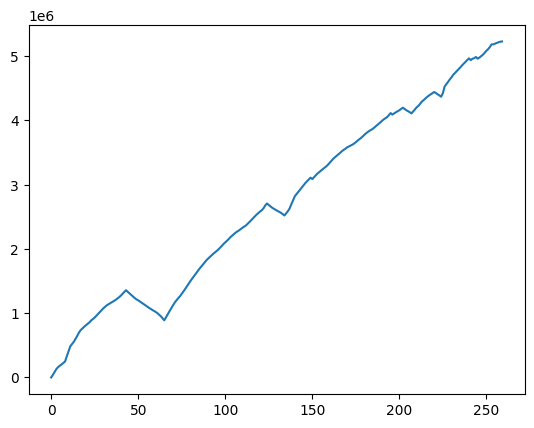

In [46]:
plt.plot(equity_curve)

In [47]:
max_drawdown = 0  # Initialize the maximum drawdown to 0
peak = equity_curve[0]  # Initialize the peak value

for i in range(1, len(equity_curve)):
    if equity_curve[i] > peak:
        peak = equity_curve[i]  # Update the peak value if a new high is reached
    else:
        drawdown = (equity_curve[i] - peak) / peak  # Calculate the drawdown
        if drawdown < max_drawdown:
            max_drawdown = drawdown  # Update the maximum drawdown if a greater drawdown is encountered
print(max_drawdown*-100,'%')

# The variable 'max_drawdown' now contains the maximum drawdown as a decimal value


34.45124648540509 %


In [49]:
maximum_drawdown=34.45

In [50]:
equity_starting=100000
total_returns = (data1['PNL'].sum() - equity_starting) / equity_starting
total_returns_percentage = total_returns * 100

sharpe_ratio = total_returns / maximum_drawdown
print(sharpe_ratio)


1.4994646850507982


# ************************ **For Tesla  Report :-) ** ******************
*             CHART Having Call and Put Signals
 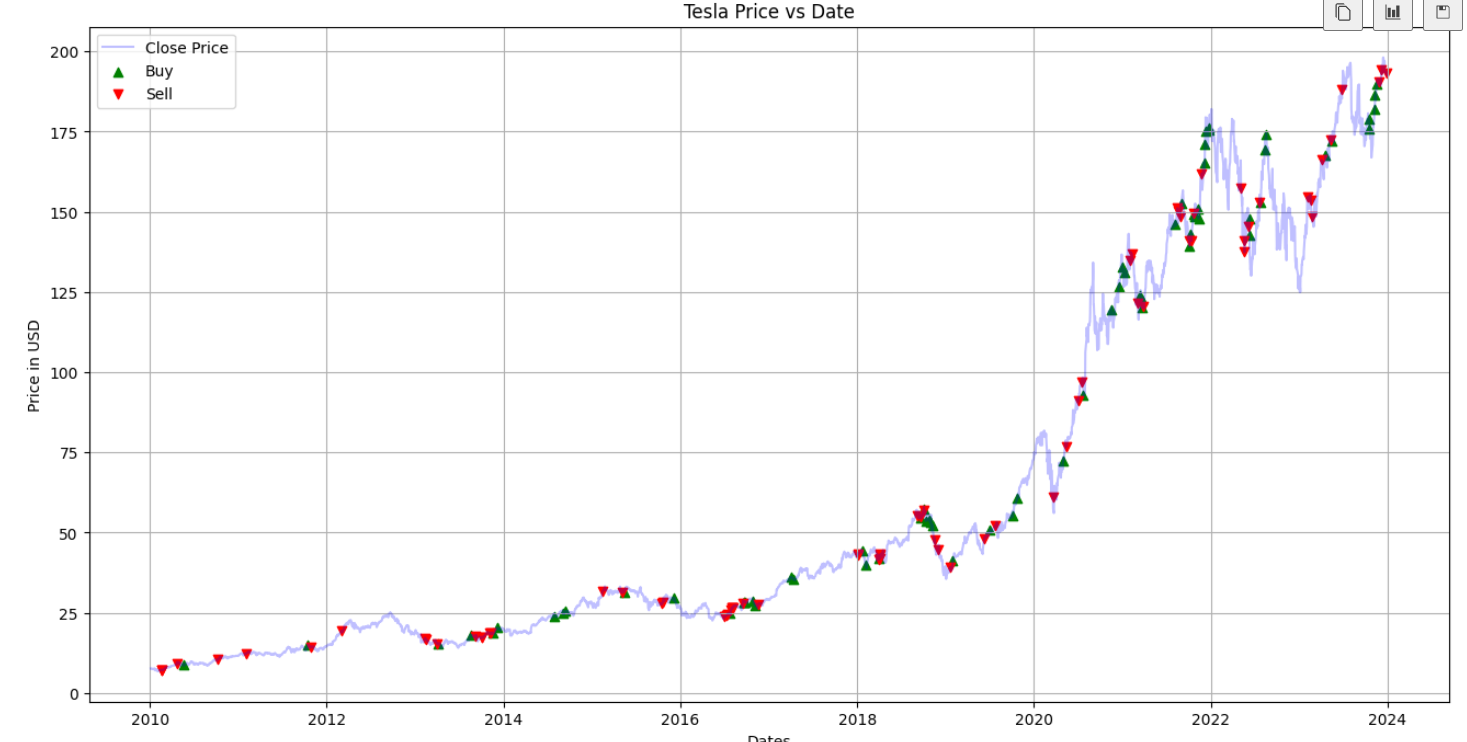
*             Final Portfolio on Tesla
 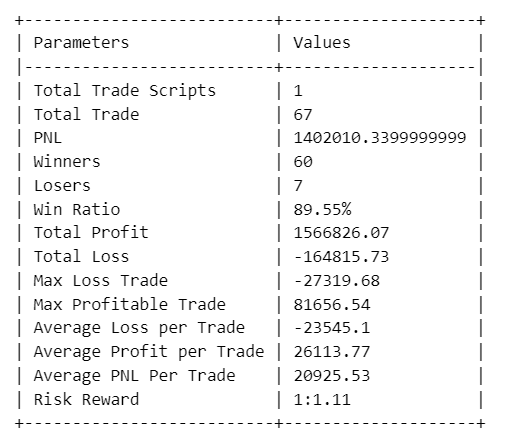


# ************************ **For APPLE  Report :-) ** ******************
*             CHART Having Call and Put Signals
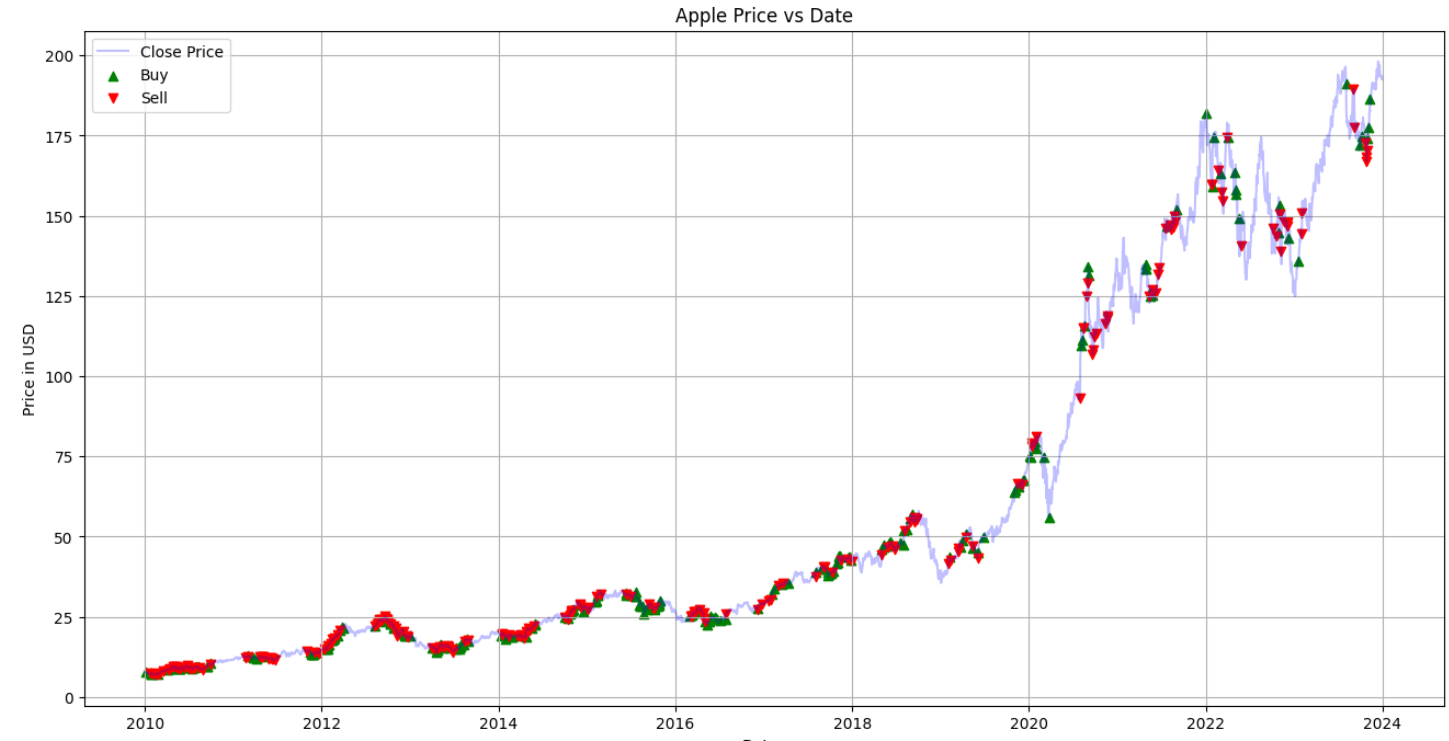
*             Final Portfolio on Tesla

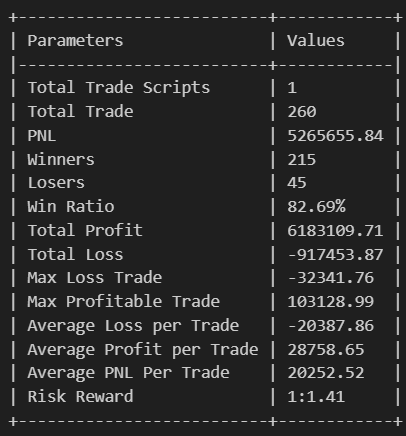
